In [1]:
# Import Libraries 
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import urllib.request
import requests
import urllib3
import folium
import re
import os
from matplotlib import font_manager as fm
from matplotlib import rc
import warnings
warnings.filterwarnings(action = 'ignore')
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Malgun Gothic'

# 데이터셋 설명
- 장애인 전용 체육시설현황
    - 출처: 생활체육정보센터
- 종목별장애인스포츠활성정보 (2020년 10월기준) 
    - 출처: Copyright kspo
- 장애인 스포츠강좌_자체크롤링 (2020년 12월초기준)
    - 출처: 국민체육진흥공단 홈페이지 (바우처)
- 장애인 스포츠강좌이용권 시설정보
    - 출처:Copyright kspo

In [2]:
# Import Dataset
prefer=pd.read_csv('data/종목별장애인스포츠활성정보.csv',encoding='cp949')
crawl=pd.read_csv('data/장애인스포츠강좌_자체 크롤링.csv',encoding='cp949')
disable=pd.read_csv('data/장애인전용체육시설현황.csv',encoding='cp949')
facility=pd.read_csv('data/장애인스포츠강좌이용권시설정보.csv',encoding='cp949')
extra_facilities=pd.read_csv('data/장애인스포츠강좌이용권시설인근편의시설정보.csv',encoding='cp949')

## 장애인전용체육시설현황 EDA
- 전국의 장애인전용 체육시설은 68곳이 존재하며 민간시설에 비해 많이 부족함.
- 시/도에 따른 장애인 전용 체육시설은 경기, 대전, 서울순으로 면적, 인구밀도에 비례하지 않는다.

In [3]:
print('전국의 장애인전용 체육시설: '+str(disable.shape[0]))

전국의 장애인전용 체육시설: 68


In [4]:
# 함수생성 
def 시설현황시각화(data,column,title):
    plt.figure(figsize = (16, 5))
    plot_data = pd.DataFrame(data[column].value_counts()).sort_values(by=column,ascending=False)

    sns.barplot(x = plot_data.index, y = column, data = plot_data)
    plt.ylabel('')
    plt.title(title,fontsize=13)

    for index, [value] in enumerate(plot_data.values):
        plt.text(index, value, value, ha = 'center', fontsize = 13)

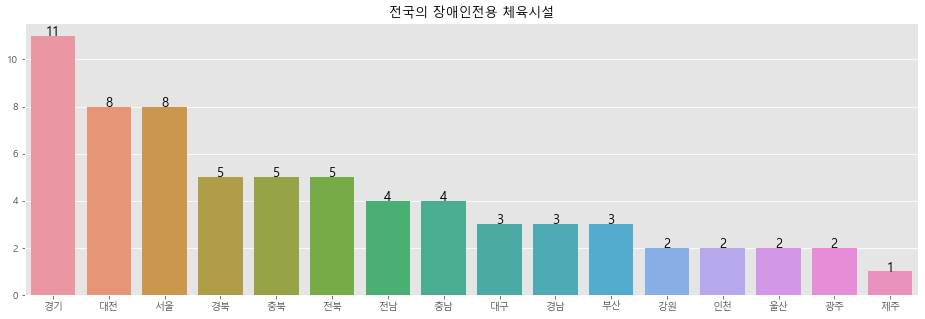

In [5]:
시설현황시각화(disable,'시/도','전국의 장애인전용 체육시설')

## 스포츠강좌이용권 시설정보 EDA
- 시설정보데이터에 대표자 전화번호, 시설상세주소가 없는 경우가 존재하긴 큰 문제가 되지않으므로 결측치처리를 하지않음.  
- 전국별 장애인 스포츠강좌이용권을 제공하는 시설수는 경기가 가장 많았으며 그 다음 서울, 대구, 부산순이다.
- 즉, 경기에서 가장 장애인관련사업에 관심이 있다고 할 수 있음.  

In [6]:
facility.isnull().sum()

시도코드        0
시도명         0
시군구코드       0
시군구명        0
시설명         0
대표자전화번호    32
우편번호        0
시설주소        0
시설상세주소     10
주요종목코드      0
주요종목명       0
시설좌표경도      0
시설좌표위도      0
강좌구분        0
dtype: int64

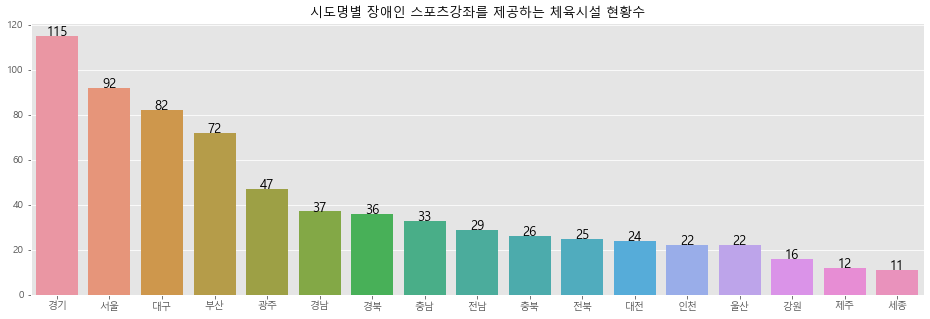

In [7]:
시설현황시각화(facility,'시도명','시도명별 장애인 스포츠강좌를 제공하는 체육시설 현황수')

## 종목별장애인스포츠활성정보 EDA

In [8]:
# 파생변수 생성
prefer['운동경험자선호비율']=(prefer['운동경험자시간여유선호비율']+prefer['운동경험자금전여유선호비율'])/2

In [9]:
# EDA를 위한 파이차트 함수 

def 파이차트시각화(labels,frequency,title):
    fig, ax= plt.subplots(figsize=(13,8))
    fig.suptitle(title,fontsize=25)
    pie = ax.pie(frequency, # 파이차트 출력
        startangle=90, # 시작점을 지정 (degree=90도) 
        counterclock=False, # 시계방향으로 그려짐 (defalut=True)   
        )
    total = np.sum(frequency)

    threshold = 5
    sum_pct = 0 # 퍼센티지
    count_less_5pct = 0 # 5%보다 작은 라벨의 개수
    spacing = 0.1
    for i,l in enumerate(labels):
        ang1, ang2 = ax.patches[i].theta1, ax.patches[i].theta2 # 파이의 시작 각도와 끝 각도
        center, r = ax.patches[i].center, ax.patches[i].r # 파이의 중심 좌표
        
        ## 비율 상한선보다 작은 것들은 계단형태로 만든다.
        if frequency[i]/total*100 < threshold:
            x = (r/2+spacing*count_less_5pct)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] # 텍스트 x좌표
            y = (r/2+spacing*count_less_5pct)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] # 텍스트 y좌표
            count_less_5pct += 1
        else:
            x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] # 텍스트 x좌표
            y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] # 텍스트 y좌표
        
        ##퍼센티지 출력
        if i < len(labels) - 1:
            sum_pct += float(f'{frequency[i]/total*100:.2f}')
            ax.text(x,y,f'{frequency[i]/total*100:.2f}%',ha='center',va='center',fontsize=12)
        else: # 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
            ax.text(x,y,f'{100-sum_pct:.2f}%',ha='center',va='center',fontsize=12)
    
    plt.legend(pie[0],labels,loc=4) # 범례 (loc=1: 오른쪽상단, loc=2: 왼쪽상단, loc=3: 왼쪽상단, loc=4: 오른쪽상단)
    plt.show()



## 대분류명별 스포츠 강좌 수 
-  대부분 강좌는 체력단련 및 생활운동 -> 무도/격투기 -> 구기 및 라켓류 순으로 이루어져있다. 


In [10]:
group=prefer.groupby(['수요운동종목대분류명']).sum()
group1=group[group['강좌종목수']!=0]
group2=group1['강좌종목수'].sort_values(ascending=False).reset_index()

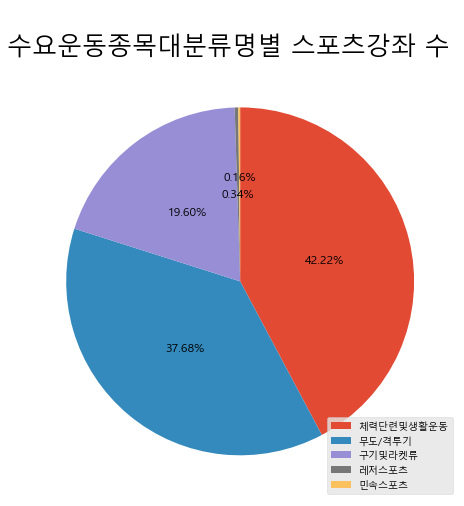

In [11]:
labels=group2['수요운동종목대분류명']
frequency=list(group2['강좌종목수'])
title='\n수요운동종목대분류명별 스포츠강좌 수'
파이차트시각화(labels,frequency,title)

##  소분류명별 스포츠 강좌 수 
- 소분류명별 스포츠강좌는 태권도(28%), 기타체력단련(19%), 수영(17.5%), 무도/격투기(11%), 탁구(6%) 순으로 강좌가 구성되어있음. 

In [12]:
course=prefer.sort_values(by='강좌종목비율',ascending=False).head(10)

In [13]:
course.head(3)

,수요운동종목대분류명,수요운동종목소분류명,운동경험자주요수요비율,운동경험자시간여유선호비율,운동경험자금전여유선호비율,비운동경험자종목선호비율,수요운동종목지수값,수요운동종목지수순위,강좌종목명,강좌종목수,강좌종목비율,운동경험자선호비율
2,무도/격투기,태권도,0.2,0.4,0.3,0.3,0.300,23,태권도,308,21.34442,0.35
40,체력단련및생활운동,체력단련및생활운동_그외종목,4.1,3.0,3.6,2.4,3.298,6,체력단련및생활운동_그외종목,210,14.55301,3.30
33,체력단련및생활운동,수영,7.2,17.0,17.1,8.4,12.532,3,수영,189,13.09771,17.05


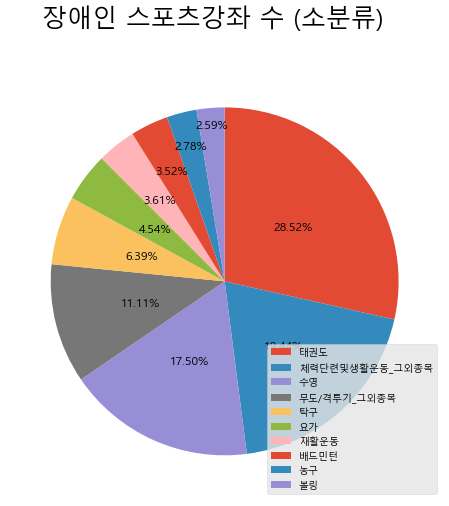

In [14]:
labels=course['수요운동종목소분류명']
frequency=list(course['강좌종목비율'])
title='장애인 스포츠강좌 수 (소분류)'
파이차트시각화(labels,frequency,title)

## 장애인 운동경험자 비경험자들 선호비율 EDA
- 운동비경험자경우 체력단련 및 생활운동 선호비율이 월등히 높은것으로 보아 장애인에 경우 새로운 운동에 대한 어려움이 보여짐.
- 운동경험자 경우 체력단련 및 생활운동의 선호율이 10% 줄어들고 기타스포츠 및 구기 및 라켓류의 선호비율이 높아졌는것을 통하여  
운동을 경험한 후 선호비율이 더 다양해졌다는 것을 알 수 있음.

In [15]:
group2=group[group['비운동경험자종목선호비율']!=0].reset_index()
labels=list(group2['수요운동종목대분류명'])
frequency=list(group2['비운동경험자종목선호비율'])
title='\n장애인 비운동경험자 선호비율'

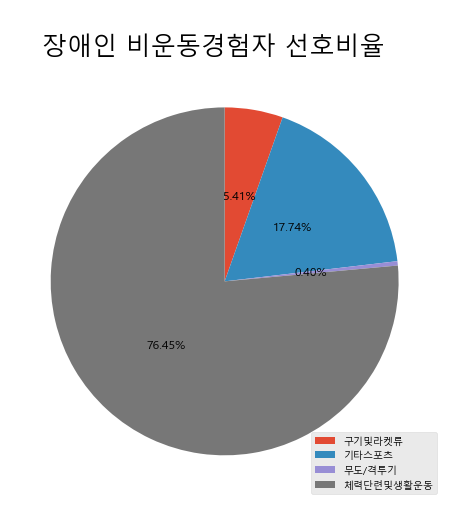

In [16]:
파이차트시각화(labels,frequency,title)

In [17]:
group2=group.sort_values('운동경험자선호비율',ascending=False).reset_index()
labels=list(group2['수요운동종목대분류명'])
frequency=list(group2['운동경험자선호비율'])
title='\n장애인 운동경험자 선호비율'

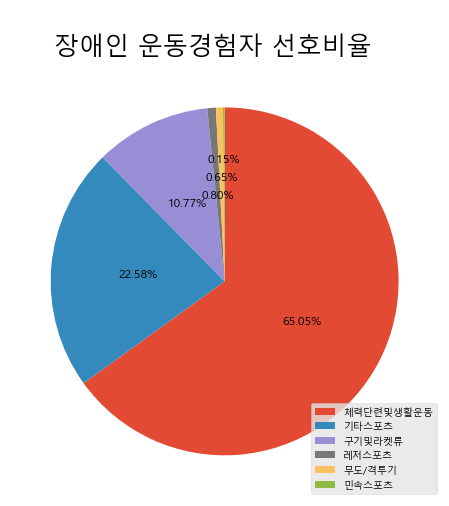

In [18]:
파이차트시각화(labels,frequency,title)

## 운동경험자 비운동경험자의 선호차이 파악
- 운동경험 후 선호비율 차이를 파생변수로 생성하여 높은 종목들을 파악
- 수영, 기타스포츠_그외종목, 요가, 자전거,사이클 그리고 웨이트트레이닝 순으로 운동경험 후 선호도가 높았다. 

In [19]:
# 운동경험자 선호 비율 파생변수 
prefer['운동경험자선호비율']=(prefer['운동경험자금전여유선호비율']+prefer['운동경험자시간여유선호비율'])/2
# 운동경험자와 비운동경험자의 선호차이
prefer['운동전후선호비율차이']=(prefer['운동경험자선호비율']-prefer['비운동경험자종목선호비율']).round(2)

In [20]:
prefer.loc[:,['수요운동종목소분류명','운동전후선호비율차이']].sort_values('운동전후선호비율차이',ascending=False).head(5)

,수요운동종목소분류명,운동전후선호비율차이
33,수영,8.65
4,기타스포츠_그외종목,3.85
38,요가,2.55
41,"자전거,사이클",1.90
39,보디빌딩(웨이트트레이닝),1.40


# 12.01 ~ 12.10 기준 강좌 (크롤링) EDA

## 강좌수 EDA
- 10월 기준 강좌수:  태권도(28%), 기타체력단련(19%), 수영(17.5%), 무도/격투기(11%), 탁구(6%)
- 12월 기준 강좌수:  기타종목(27%), 태권도(23%), 수영(18%), 헬스(12%), 탁구(4%)
- 10월과 12월에 상위 강좌 종목수의 변화가 있었지만 큰 차이는 없음. 
- 첫번째로 선호비율이 증가했던 기타스포츠_그외종목 카테고리에는 *특수체육*, 뉴스포츠, 4구등의 수업이 존재함 
    - *특수체육* 에서 '특수'는 장애인 또는 특숙육대상자를 의미한다. (출처) https://m.blog.naver.com/wsrthfk1/222013114868

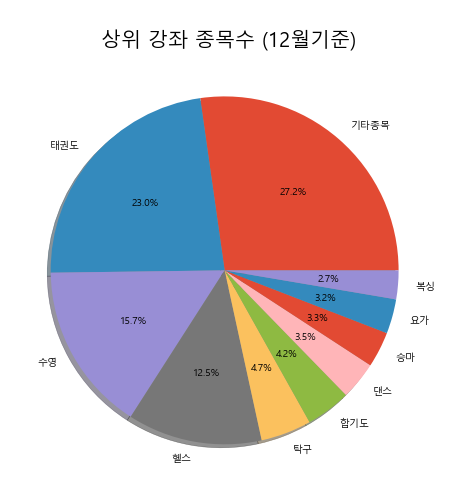

In [21]:
# 강좌 종류 상위 10개 시각화 
운동종목수=crawl['운동종류'].value_counts().head(10)
plt.figure(figsize = (8, 8))
plt.pie(x=운동종목수,labels=운동종목수.index,autopct='%.1f%%',shadow=True)
plt.title('\n 상위 강좌 종목수 (12월기준)',fontsize=20)
plt.show()

In [22]:
crawl[crawl['운동종류']=='기타종목'].loc[:,['운동종류','강의명']].value_counts().head(5)

운동종류  강의명              
기타종목  [12월] 특수체육           43
      [12월] 뉴스포츠            9
      [12월] 그룹강좌            3
      [12월] 4구당구 입문(초보)     3
      [12월] 보치아교실           3
dtype: int64

In [23]:
# 컬럼자료형 확인
crawl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   시설명      1108 non-null   object 
 1   대표자      1102 non-null   object 
 2   연락처      1108 non-null   object 
 3   시도       1108 non-null   object 
 4   시군구      1108 non-null   object 
 5   지도자      1108 non-null   object 
 6   시설면적     1108 non-null   object 
 7   운동종류     1108 non-null   object 
 8   장애종류     1108 non-null   object 
 9   강의명      1108 non-null   object 
 10  시간       1108 non-null   object 
 11  요일       1108 non-null   object 
 12  강사명      1098 non-null   object 
 13  기간       1108 non-null   object 
 14  차량지원     1108 non-null   object 
 15  장애 지원시설  666 non-null    object 
 16  수강료      1108 non-null   object 
 17  경도       1108 non-null   float64
 18  위도       1108 non-null   float64
dtypes: float64(2), object(17)
memory usage: 164.6+ KB


In [24]:
# 수강료 컬럼 자료형 변경 (범주형에서 숫자형)
for index in range(crawl.shape[0]):
    crawl['수강료']=crawl.수강료.str.replace(',','')
crawl['수강료']=crawl['수강료'].astype('int')


In [25]:
# 수강료 범주형에서 숫자형변수로 변환
# 실제부담금액 파생변수만들기 
crawl['실금액']=crawl['수강료']-80000
crawl['실금액2']=crawl['수강료']-80000

In [26]:
# 데이터값 구간화 
def 실금액(x):
    if x== 0 : return '무료강좌'
    elif x<50000 : return '5만원이하'
    elif x<100000 : return '10만원이하'
    else: return '10만원이상'


In [27]:
# 데이터값 구간화2
def 실금액2(x):
    if x<20000 : return '2만원이하'
    elif x<50000 : return '5만원이하'
    elif x<100000 : return '10만원이하'
    else: return '10만원이상'

In [28]:
crawl['실금액'] = crawl['실금액'].apply(실금액)
crawl['실금액2'] = crawl['실금액2'].apply(실금액2)

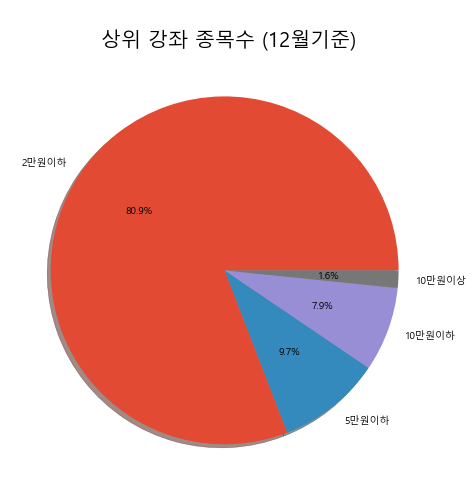

In [29]:
#  구간화2 적용후 시각화
실금액=crawl['실금액2'].value_counts().head(10)
plt.figure(figsize = (8, 8))
plt.pie(x=실금액,labels=실금액.index,autopct='%.1f%%',shadow=True)
plt.title('\n 상위 강좌 종목수 (12월기준)',fontsize=20)
plt.show()

## 무료 스포츠강좌
- 스포츠강좌이용권 연간 지원금이 8만원 지원되므로 강좌금액 - 8만원 = 0원인 경우 무료강좌로 간주함
- 기타종목(특수체육), 태권도, 헬스, 수영, 탁구 순으로 무료강좌비율이 구성되어있음.


In [30]:
크롤링_무료강좌=crawl[crawl['실금액']=='무료강좌']

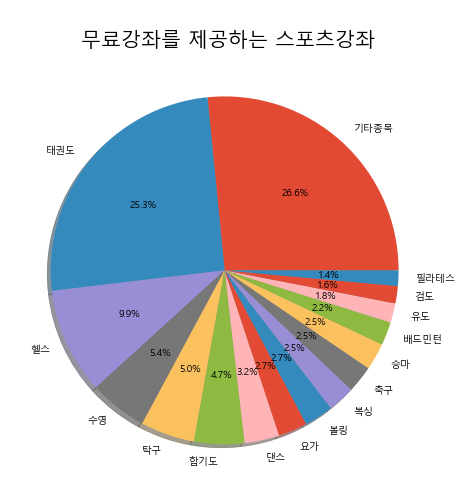

In [31]:
운동종목수=크롤링_무료강좌['운동종류'].value_counts().head(16)
plt.figure(figsize = (8, 8))
plt.pie(x=운동종목수,labels=운동종목수.index,autopct='%.1f%%',shadow=True)
plt.title('\n 무료강좌를 제공하는 스포츠강좌',fontsize=20)
plt.show()

## 장애인스포츠강좌이용권시설인근편의시설정보 EDA

In [32]:
print('인근편의시설데이터: ' ,extra_facilities.shape)
extra_facilities.head(3)

인근편의시설데이터:  (391035, 22)


,체육시설시도코드,체육시설시도명,체육시설시군구코드,체육시설시군구명,체육시설명,체육시설대표자전화번호,체육시설우편번호,체육시설주소,체육시설상세주소,체육시설주요종목코드,...,체육시설위도,편의시설ID,편의시설설립일자,편의시설명,편의시설경도,편의시설위도,편의시설유형코드,편의시설유형명,편의시설주소,체육편의시설거리
0,11,서울,11410,서대문구,매직짐,23798815.0,3628,서울특별시 서대문구 통일로 484,유진상가2층 매직짐(홍제동),25,...,37.591589,681,19920220.0,천연동주민센터,126.959068,37.571113,UC0A03,지역자치센터,서울특별시 서대문구 성산로 64,2.682
1,11,서울,11500,강서구,박사 경희대 태권도,220655599.0,7722,서울특별시 강서구 까치산로10길 73,2층(화곡동),22,...,37.540887,18726,20100106.0,현대홈타운,126.834523,37.528751,UC0U04,다세대주택,서울특별시 양천구 남부순환로63길 12,1.790
2,11,서울,11500,강서구,박사 경희대 태권도,220655599.0,7722,서울특별시 강서구 까치산로10길 73,2층(화곡동),22,...,37.540887,77609,20030626.0,내츄럴2차,126.832856,37.551746,UC0U01,아파트,서울특별시 강서구 강서로47마길 37-22,1.791


In [33]:
extra_facilities.isnull().sum()

체육시설시도코드            0
체육시설시도명             0
체육시설시군구코드           0
체육시설시군구명            0
체육시설명               0
체육시설대표자전화번호     14252
체육시설우편번호            0
체육시설주소              0
체육시설상세주소         3067
체육시설주요종목코드          0
체육시설주요종목명           0
체육시설경도              0
체육시설위도              0
편의시설ID              0
편의시설설립일자       157522
편의시설명               0
편의시설경도              0
편의시설위도              0
편의시설유형코드            0
편의시설유형명             0
편의시설주소              0
체육편의시설거리            0
dtype: int64

In [34]:
extra_facilities.columns

Index(['체육시설시도코드', '체육시설시도명', '체육시설시군구코드', '체육시설시군구명', '체육시설명', '체육시설대표자전화번호',
       '체육시설우편번호', '체육시설주소', '체육시설상세주소', '체육시설주요종목코드', '체육시설주요종목명', '체육시설경도',
       '체육시설위도', '편의시설ID', '편의시설설립일자', '편의시설명', '편의시설경도', '편의시설위도', '편의시설유형코드',
       '편의시설유형명', '편의시설주소', '체육편의시설거리'],
      dtype='object')

In [35]:
extra_facilities['편의시설유형명'].unique()

array(['지역자치센터', '다세대주택', '아파트', '금융업소 등 일반업무시설', '수퍼마켓·일용품 등의 소매점',
       '일반숙박시설(호텔, 여관)', '교육원·직업훈련소·학원 등', '의원·치과의원·한의원·조산소(산후조리원)',
       '우체국', '어린이집', '병원·치과병원·한방병원·정신병원·요양병원', '일반음식점', '고등학교', '중학교',
       '유치원', '노인복지시설(경로당포함)', '초등학교', '종교집회장', '이용원·미용원·목욕장', '종합병원',
       '아파트 부대복리시설', '집회장', '운동장', '파출소, 지구대', '국가 또는 지자체 청사',
       '도매·소매시장·상점', '아동복지시설', '공장', '공중화장실', '방송국', '공연장', '주차장',
       '이외 사회복지시설', '관광숙박시설(관광호텔, 콘도등)', '장애인복지시설', '국민건강보험공단 및 지사',
       '전문대학', '생활권수련시설', '연립주택', '대학교', '전시장', '자연공원', '특수학교', '기숙사',
       '휴게음식점·제과점', '대피소', '체육관', '전신전화국', '도서관', '도시공원', '공공도서관',
       '지역아동센터', '보건소', '장례식장(의료시설의 부수시설제외)', '근로복지공단 및 지사',
       '국민연금공단 및 지사', '야외음악당·야외극장·어린이회관', '관람장', '동·식물원', '자연권수련시설',
       '한국장애인고용공단 및 지사', '안마시술소', '운전학원', '휴게소', '격리병원', '교도소·구치소',
       '화장시설', '봉안당(종교시설에 해당하는 것은 제외)'], dtype=object)

In [69]:
# 장애인에게 도움이 될만한 시설들을 리스트 
listfordisable=['지역자치센터','병원·치과병원·한방병원·정신병원·요양병원','종합병원','이외 사회복지시설','장애인복지시설','보건소','한국장애인고용공단 및 지사']

In [70]:
extra_facilities2=extra_facilities[extra_facilities['편의시설유형명'].isin(listfordisable)].loc[:,['체육시설시도명','체육시설명','체육시설주요종목명','체육시설경도','체육시설위도','편의시설명','편의시설유형명','편의시설경도','편의시설위도','체육편의시설거리']]

In [114]:
seoul=extra_facilities2[(extra_facilities2['체육시설시도명']=='서울')&(extra_facilities2['체육편의시설거리']<0.5)]

In [131]:
list=extra_facilities2['체육시설시도명'].unique().tolist()

In [134]:
list[1]


'부산'

In [156]:
seoul

,체육시설시도명,체육시설명,체육시설주요종목명,체육시설경도,체육시설위도,편의시설명,편의시설유형명,편의시설경도,편의시설위도,체육편의시설거리
387016,제주,볼리션 장애인 밸런스 센터,헬스,126.531514,33.495325,상이군경복지회관,이외 사회복지시설,126.531842,33.493309,0.226
387361,제주,스마트댄스컴퍼니,기타종목,126.485767,33.480257,미래산부인과,병원·치과병원·한방병원·정신병원·요양병원,126.484357,33.481659,0.203
388309,제주,탑홀스스크린승마신제주점,승마,126.486810,33.484179,미래산부인과,병원·치과병원·한방병원·정신병원·요양병원,126.484357,33.481659,0.361
388912,제주,신광태권도,태권도,126.486853,33.492214,한라병원,병원·치과병원·한방병원·정신병원·요양병원,126.484917,33.490259,0.282
389951,제주,서귀포시장애인종합복지관,기타종목,126.584584,33.286915,서귀포장애인종합복지관,장애인복지시설,126.584583,33.286916,0.000
389952,제주,서귀포시장애인종합복지관,기타종목,126.584584,33.286915,어울림터,장애인복지시설,126.583787,33.287454,0.095
390010,제주,승무태권도장,태권도,126.260653,33.223699,서부보건소,보건소,126.256266,33.225172,0.440
390635,제주,볼리션장애인밸런스센터,헬스,126.531514,33.495325,상이군경복지회관,이외 사회복지시설,126.531842,33.493309,0.226


In [198]:
for i in range(len(list)):
    globals()['지역_{}'.format(i)]=extra_facilities2[(extra_facilities2['체육시설시도명']==list[i])&(extra_facilities2['체육편의시설거리']<0.5)]
    center = [36.8658926,127.2101321]
    globals()['map_{}'.format(i)]=folium.Map(location=center,zoom_start=7)

In [213]:
지역_1

,체육시설시도명,체육시설명,체육시설주요종목명,체육시설경도,체육시설위도,편의시설명,편의시설유형명,편의시설경도,편의시설위도,체육편의시설거리
94186,부산,자연체육관,태권도,129.039306,35.118619,초량3동주민센터,지역자치센터,129.039794,35.121318,0.303
94200,부산,자연체육관,태권도,129.039306,35.118619,척시원병원건물,병원·치과병원·한방병원·정신병원·요양병원,129.038775,35.114410,0.470
94632,부산,새론스포텍스쿼시,스쿼시,129.010290,35.235644,한마음메디컬센터,병원·치과병원·한방병원·정신병원·요양병원,129.014355,35.235979,0.371
94637,부산,새론스포텍스쿼시,스쿼시,129.010290,35.235644,화명3동주민센터,지역자치센터,129.010047,35.231867,0.421
94772,부산,비타민헬스크럽,헬스,128.994532,35.196741,구포부민병원,병원·치과병원·한방병원·정신병원·요양병원,128.990545,35.198322,0.403
...,...,...,...,...,...,...,...,...,...,...
140909,부산,트윈스짐,헬스,129.010499,35.211161,드림 메디칼 빌딩,병원·치과병원·한방병원·정신병원·요양병원,129.007559,35.210340,0.282
141732,부산,국민태권도,태권도,129.106009,35.204056,명장1동주민센터,지역자치센터,129.104249,35.204697,0.175
141986,부산,승리마루백양태권도장,태권도,129.032675,35.207631,부산시노인전문병원,병원·치과병원·한방병원·정신병원·요양병원,129.028207,35.206150,0.438
142527,부산,라온태권도,태권도,129.103820,35.175135,사랑나눔장애인주간보호센터,장애인복지시설,129.100129,35.174154,0.353


In [217]:
for i in range(16):
    data=지역_i
    # for i in range(len(data)):
    #     folium.Marker(
    #         location=[data.iloc[i][8],data.iloc[i][7]],
    #         radius=10
    #     ).add_to(map_i)

NameError: name '지역_17' is not defined

In [118]:
seoul=seoul.drop_duplicates(subset=['체육시설경도','체육시설위도'],keep='last')
for i in range(len(seoul)):
    folium.Marker(
        location=[seoul.iloc[i][4],seoul.iloc[i][3]],
        icon=folium.Icon(color='red',icon='ok'),
        radius=10
    ).add_to(m)

In [120]:
m.save('편의시설.html')

In [173]:
지역_1

,체육시설시도명,체육시설명,체육시설주요종목명,체육시설경도,체육시설위도,편의시설명,편의시설유형명,편의시설경도,편의시설위도,체육편의시설거리
94186,부산,자연체육관,태권도,129.039306,35.118619,초량3동주민센터,지역자치센터,129.039794,35.121318,0.303
94200,부산,자연체육관,태권도,129.039306,35.118619,척시원병원건물,병원·치과병원·한방병원·정신병원·요양병원,129.038775,35.114410,0.470
94632,부산,새론스포텍스쿼시,스쿼시,129.010290,35.235644,한마음메디컬센터,병원·치과병원·한방병원·정신병원·요양병원,129.014355,35.235979,0.371
94637,부산,새론스포텍스쿼시,스쿼시,129.010290,35.235644,화명3동주민센터,지역자치센터,129.010047,35.231867,0.421
94772,부산,비타민헬스크럽,헬스,128.994532,35.196741,구포부민병원,병원·치과병원·한방병원·정신병원·요양병원,128.990545,35.198322,0.403
...,...,...,...,...,...,...,...,...,...,...
140909,부산,트윈스짐,헬스,129.010499,35.211161,드림 메디칼 빌딩,병원·치과병원·한방병원·정신병원·요양병원,129.007559,35.210340,0.282
141732,부산,국민태권도,태권도,129.106009,35.204056,명장1동주민센터,지역자치센터,129.104249,35.204697,0.175
141986,부산,승리마루백양태권도장,태권도,129.032675,35.207631,부산시노인전문병원,병원·치과병원·한방병원·정신병원·요양병원,129.028207,35.206150,0.438
142527,부산,라온태권도,태권도,129.103820,35.175135,사랑나눔장애인주간보호센터,장애인복지시설,129.100129,35.174154,0.353


2